# Data description & Problem statement: 
Retail is another industry which extensively uses analytics to optimize business processes. Tasks like product placement, inventory management, customized offers, product bundling, etc. are being smartly handled using data science techniques. As the name suggests, this data comprises of transaction records of a sales store. This is a Regression problem. The data has 8523 rows of 12 variables.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Cross-validation of Linear Regression model with L1 regularization
- Cross-validation of Linear Regression model with L2 regularization
- Use grid-search along with C-V approach to find the best hyperparameters of Linear Regression model with both L1 & L2 regularizations: Find the best Linear model
   # Model Evaluation: 
- Evaluate the best Linear model with optimized hyperparameters on Test Dataset, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 
     - Box-plot for prediction Vs. actual values 
     - Distribution plot of error/residuals

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Big mart sales/Train.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Weight' ], axis=1, inplace=True)
df['Item_Fat_Content']=df['Item_Fat_Content'].map({'Low Fat':'L', 'low fat':'L', 'LF':'L', 'Regular':'R', 'reg':'R'})


df.head(3)

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,L,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,R,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,L,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [3]:
df.loc[df['Outlet_Establishment_Year']== 1998]= df.loc[df['Outlet_Establishment_Year'] == 1998].fillna('small')

df.dropna(axis=0, inplace=True)
df.shape

(6668, 9)

In [4]:
L_con=['Item_Visibility', 'Item_MRP' ]
L_cat=['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
L_nom=['Item_Fat_Content', 'Item_Type', 'Outlet_Establishment_Year']

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

for i in L_cat:
    encode_text_index(df, i)
    
for i in L_nom:
    encode_text_index(df, i)
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
for name in ['Item_Type']:
    encode_text_dummy(df, name)

In [5]:
X=df.drop(['Item_Outlet_Sales'], axis=1)
y=np.sqrt(df['Item_Outlet_Sales'])

In [6]:
# Re-scaling & Polynomial Interactions:
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=2, include_bias=False)
X=poly.fit(X).transform(X)

X.shape

(6668, 299)

In [7]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalor_X=MinMaxScaler().fit(pd.DataFrame(X_train))
X_train=scalor_X.transform(pd.DataFrame(X_train))
X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y_train))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

Max. Lasso score =  0.6951270902813637


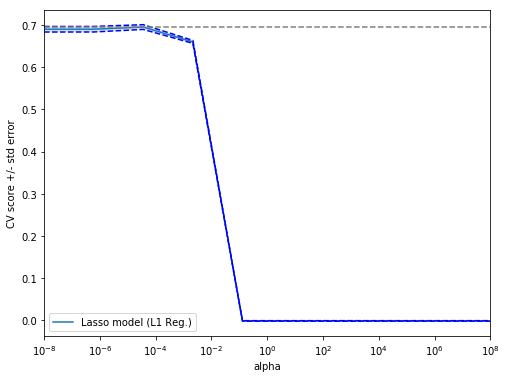

In [8]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Cross-Validation for Lasso algorithm: L1 Regularization
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = Lasso(random_state=42)
alphas = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds=3
kfold= KFold(n_splits=n_folds, shuffle=True, random_state=42)

for alpha in alphas:
    model.alpha = alpha
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Lasso score = ", np.max(scores))

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.legend(['Lasso model (L1 Reg.)'])

Max. Ridge score =  0.6903676491882629


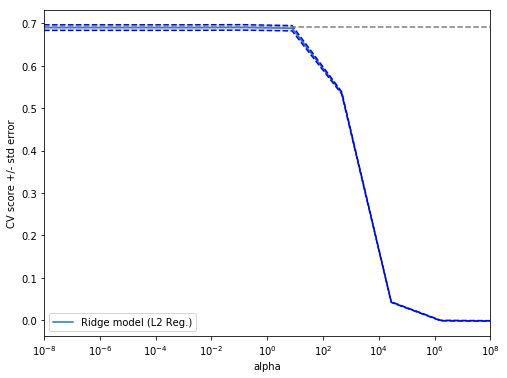

In [9]:
# Cross-Validation for Ridge algorithm: L2 Regularization
model = Ridge(random_state=42)

scores = list()
scores_std = list()

n_folds=3
kfold= KFold(n_splits=n_folds, shuffle=True, random_state=42)

for alpha in alphas:
    model.alpha = alpha
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    
scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Ridge score = ", np.max(scores))

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.legend(['Ridge model (L2 Reg.)'])

In [10]:
# Grid-Serach for the best ElasticNet parameters: 
from sklearn.model_selection import GridSearchCV

param={'l1_ratio':[0, 0.1, 0.2, 0.3, 0.5, 0.7, 1], 'alpha': [0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]}

kfold=KFold(n_splits=3, shuffle=True, random_state=42)

grid_search=GridSearchCV(ElasticNet(), param, cv=kfold, n_jobs=-1)
grid_search.fit(X_train, y_train)

G=pd.DataFrame(grid_search.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
27,1.811153,0.075731,0.001995,1.946680e-07,0.0001,1,"{'alpha': 0.0001, 'l1_ratio': 1}",0.706516,0.683623,0.704812,0.698317,0.010413,1,0.709510,0.719392,0.708771,0.712558,0.004842
26,2.200113,0.098640,0.001665,4.655822e-04,0.0001,0.7,"{'alpha': 0.0001, 'l1_ratio': 0.7}",0.705422,0.683121,0.703737,0.697427,0.010139,2,0.711423,0.721251,0.710575,0.714417,0.004845
31,0.934500,0.166410,0.001662,4.699093e-04,0.0005,0.3,"{'alpha': 0.0005, 'l1_ratio': 0.3}",0.705743,0.681579,0.703374,0.696899,0.010875,3,0.704501,0.715260,0.704218,0.707993,0.005140


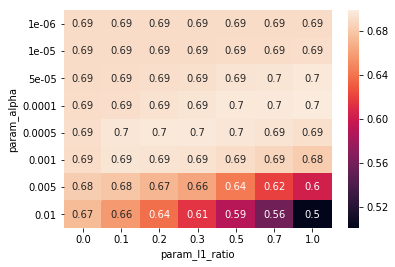

In [11]:
h=G[["param_alpha", "param_l1_ratio", "mean_test_score"]].pivot_table(index="param_alpha", columns="param_l1_ratio", values="mean_test_score")
sns.heatmap(h, annot=True)

In [12]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation score:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[0,"std_test_score"], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'alpha': 0.0001, 'l1_ratio': 1}
Best validation score:  0.70 (+/- 0.01)
Test score:  0.7


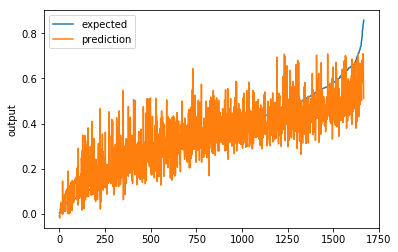

In [13]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=grid_search.predict(X_test)
chart_regression(pred.flatten(), y_test, sort=True)

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(y_test_inv**2, pred_inv**2))
print('Test rmse: ', rmse)

Test rmse:  1113.2901338474735


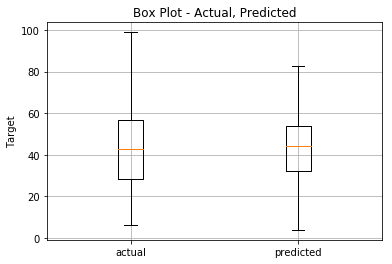

In [15]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

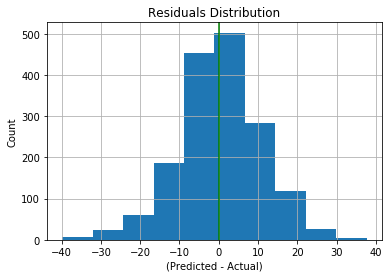

In [16]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()